***Importing Libraries***

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Display charts directly in the notebook
%matplotlib inline

# Style configuration for professional-looking charts
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries Imported Successfully")

Libraries Imported Successfully


**Loading Datatset**

In [3]:
df = pd.read_csv("clean_internship_data.csv")
print("Df shape is ",df.shape)
display(df.head(5))

Df shape is  (2333, 6)


,job_title,company,location,raw_content,job_url,category
0,IT - Business Analyst,GRT Global Logistics Private Limited,Mumbai,IT - Business Analyst|GRT Global Logistics Pri...,https://internshala.com/internship/detail/it-b...,data-science
1,Business Development Executive – Creator Partn...,Bevysquare Social Private Limited,Noida,Business Development Executive – Creator Partn...,https://internshala.com/internship/detail/busi...,data-science
2,Digital Marketing,Plan D Media,Kolkata(Hybrid),Digital Marketing|Plan D Media|Actively hiring...,https://internshala.com/internship/detail/digi...,data-science
3,Growth Marketing,Humanhire Corp,Jaipur,Growth Marketing|Humanhire Corp|Actively hirin...,https://internshala.com/internship/detail/grow...,data-science
4,Social Media Marketing And Lead Generation Exe...,Acumensa Technologies,Work from home,Social Media Marketing And Lead Generation Exe...,https://internshala.com/internship/detail/work...,data-science


**Extracting Stipend And Duration using Regex**

In [4]:
def extract_stipend(text):
    """
    Extracts stipend text like '₹ 10,000 /month' or '₹ 2,000-5,000 /month'
    Returns the text string or 'Unpaid' if not found.
    """
    text = str(text)
    # Regex to find money patterns (e.g., ₹ 10,000 or 10000)
    match = re.search(r'₹\s*([\d,]+(?:\s*-\s*[\d,]+)?)|(\d{3,5})\s*/month', text)
    if match:
        return match.group(0)
    if "Unpaid" in text:
        return "Unpaid"
    return "Negotiable/Na"

def extract_duration(text):
    """
    Extracts duration like '3 Months' or '6 Weeks'
    """
    text = str(text)
    # Regex to find number + Month/Week
    match = re.search(r'(\d+)\s*(Month|Week)s?', text, re.IGNORECASE)
    if match:
        return match.group(0)
    return "N/A"

# Apply the functions
df['stipend_text'] = df['raw_content'].apply(extract_stipend)
df['duration_text'] = df['raw_content'].apply(extract_duration)

print("Extraction Complete. ")
display(df[['stipend_text', 'duration_text']].head())

Extraction Complete. 


,stipend_text,duration_text
0,"₹ 8,000 - 10,000",6 Months
1,"₹ 8,000 - 10,000",2 Months
2,"₹ 9,000 - 11,000",4 Months
3,"₹ 8,000 - 11,500",6 Months
4,"₹ 10,000 - 25,000",3 Months


**Data cleaning and feature engineering**

In [5]:

def clean_money(value):
    """
    Converts stipend text to a single number (Average of range).
    Ex: '₹ 10,000-15,000' -> 12500.0
    """
    if pd.isna(value) or isinstance(value, float):
        return 0
    if "Unpaid" in str(value) or "Na" in str(value):
        return 0
    
    # Remove all non-digit characters except hyphen
    clean_str = re.sub(r'[^\d-]', '', str(value))
    
    try:
        if '-' in clean_str:
            low, high = map(int, clean_str.split('-'))
            return (low + high) / 2
        return float(clean_str)
    except:
        return 0

# --- STEP 2: CATEGORIZE ROLE  ---
def categorize_role(title):
    """
    Buckets job titles into industry categories.
    Now captures 'Machine Learning', 'Business Analytics', 'Cloud', etc.
    """
    title = str(title).lower()
    
    # Expanded Keyword Lists
    ds_keywords = [
        'data', 'science', 'analyst', 'analytics', 'ai', 'ml', 
        'machine learning', 'deep learning', 'vision', 'nlp', 
        'natural language', 'neural', 'business intelligence', 'bi', 'stat'
    ]
    
    web_keywords = [
        'web', 'software', 'developer', 'stack', 'react', 'node', 
        'django', 'python', 'java', 'frontend', 'backend', 'app', 
        'android', 'ios', 'cloud', 'devops', 'engineer'
    ]
    
    marketing_keywords = [
        'marketing', 'social', 'seo', 'content', 'growth', 
        'digital', 'media', 'brand'
    ]
    
    design_keywords = [
        'design', 'graphic', 'ui', 'ux', 'video', 'editor', 
        'creative', 'art', 'animator'
    ]

    # Matching Logic
    if any(x in title for x in ds_keywords):
        return 'Data Science & AI'
    elif any(x in title for x in web_keywords):
        return 'Web/Software Dev'
    elif any(x in title for x in marketing_keywords):
        return 'Marketing & Growth'
    elif any(x in title for x in design_keywords):
        return 'Design & Creative'
    else:
        return 'Other'

# --- STEP 3: APPLY TO DATAFRAME ---
df['stipend_numeric'] = df['stipend_text'].apply(clean_money)
df['category'] = df['job_title'].apply(categorize_role)
df['is_remote'] = df['location'].str.contains('Work from home', case=False, na=False)

print(" Data Cleaned & Categorized ")



 Data Cleaned & Categorized 


**Validating CSV**

In [6]:
# 1. Create a "View" of just the important columns (hiding the messy raw text)
view_columns = ['job_title', 'company', 'category', 'stipend_text', 'stipend_numeric', 'is_remote']

# 2. first 5 rows
print("--- HEAD (First 5 Rows) ---")
display(df[view_columns].head())

# 3.RANDOM sample of 5 rows (checking random data)
print("\n--- RANDOM SAMPLE (Check for variety) ---")
display(df[view_columns].sample(15))

# 4. Checking specific edge cases to ensure math is correct
print("\n--- CHECKING STIPEND MATH ---")
# Show rows where we found a stipend range (e.g., 10000-15000) to see if it averaged correctly
range_rows = df[df['stipend_text'].str.contains('-', na=False)]
if not range_rows.empty:
    display(range_rows[view_columns].head(3))
else:
    print("No stipend ranges found in this batch.")

--- HEAD (First 5 Rows) ---


,job_title,company,category,stipend_text,stipend_numeric,is_remote
0,IT - Business Analyst,GRT Global Logistics Private Limited,Data Science & AI,"₹ 8,000 - 10,000",9000.0,False
1,Business Development Executive – Creator Partn...,Bevysquare Social Private Limited,Design & Creative,"₹ 8,000 - 10,000",9000.0,False
2,Digital Marketing,Plan D Media,Marketing & Growth,"₹ 9,000 - 11,000",10000.0,False
3,Growth Marketing,Humanhire Corp,Marketing & Growth,"₹ 8,000 - 11,500",9750.0,False
4,Social Media Marketing And Lead Generation Exe...,Acumensa Technologies,Marketing & Growth,"₹ 10,000 - 25,000",17500.0,True



--- RANDOM SAMPLE (Check for variety) ---


,job_title,company,category,stipend_text,stipend_numeric,is_remote
2,Digital Marketing,Plan D Media,Marketing & Growth,"₹ 9,000 - 11,000",10000.0,False
2044,Mern Stack,Maxgen Technologies Private Limited,Web/Software Dev,"₹ 5,000 - 12,000",8500.0,False
1014,AI/ML Developer,Triluxo Technologies Private Limited,Data Science & AI,"₹ 10,000 - 15,000",12500.0,True
1611,Front End Development,Emoolar Technology Private Limited,Other,"₹ 8,000 - 11,000",9500.0,True
490,Video Editor,Moksha Media Production,Design & Creative,"₹ 10,000 - 15,000",12500.0,False
509,Data Science Trainee,Insta Dot Analytics,Data Science & AI,"₹ 8,000 - 15,000",11500.0,False
1299,Front End Development,Aadhvik Technologies,Other,"₹ 2,000 - 3,000",2500.0,True
729,Business Analytics,Sumosave Retail Ventures,Data Science & AI,"₹ 18,000 - 25,000",21500.0,False
226,Unknown,Unknown,Other,₹9,9.0,False
571,Computer Vision,Vyorius Drones Private Limited,Data Science & AI,"₹ 3,000 - 5,000",4000.0,True



--- CHECKING STIPEND MATH ---


,job_title,company,category,stipend_text,stipend_numeric,is_remote
0,IT - Business Analyst,GRT Global Logistics Private Limited,Data Science & AI,"₹ 8,000 - 10,000",9000.0,False
1,Business Development Executive – Creator Partn...,Bevysquare Social Private Limited,Design & Creative,"₹ 8,000 - 10,000",9000.0,False
2,Digital Marketing,Plan D Media,Marketing & Growth,"₹ 9,000 - 11,000",10000.0,False


**Visualizing Top paying skills**

C:\Users\krish\AppData\Local\Temp\ipykernel_14312\828913329.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=job_counts.index, y=job_counts.values, ax=ax1, palette='viridis')
C:\Users\krish\AppData\Local\Temp\ipykernel_14312\828913329.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_stipend.index, y=avg_stipend.values, ax=ax2, palette='magma')


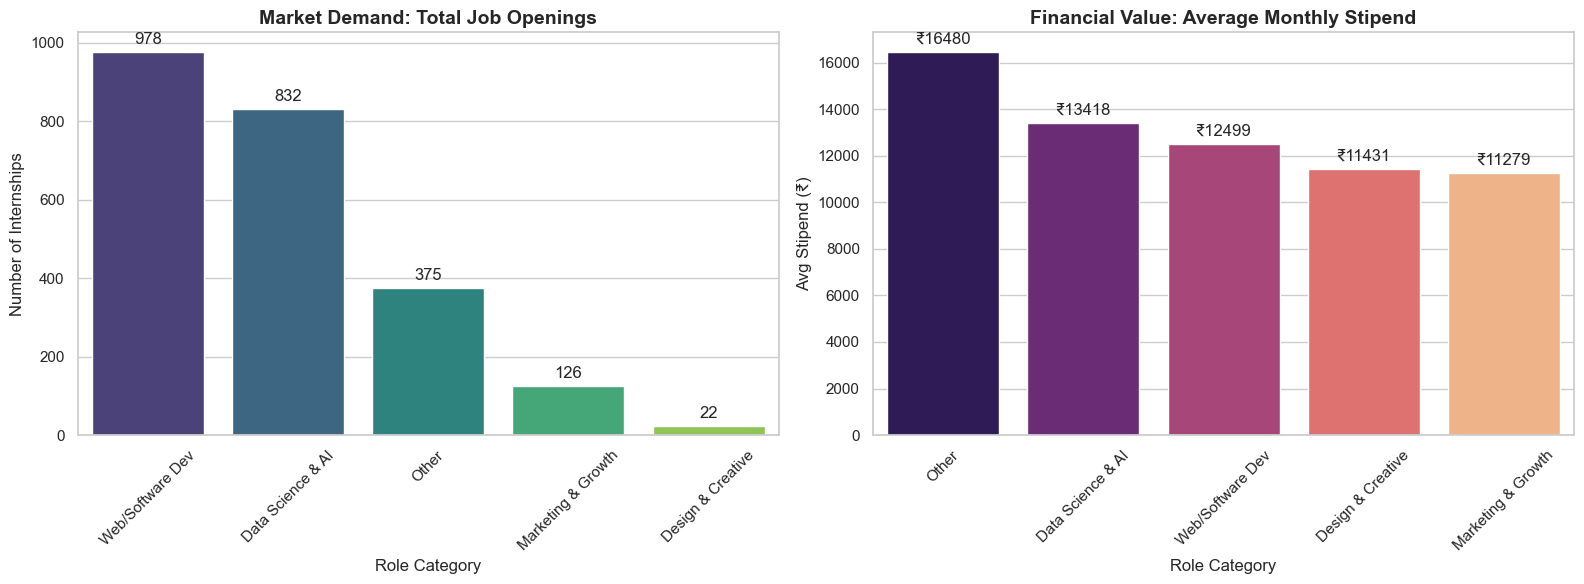

In [ ]:
# --- MARKET DEMAND & VALUE ANALYSIS ---


job_counts = df['category'].value_counts()

# Calculating average stipend (excluding unpaid ones for accuracy)
avg_stipend = df[df['stipend_numeric'] > 0].groupby('category')['stipend_numeric'].mean().sort_values(ascending=False)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# CHART 1: Market Volume (Who is hiring?)
sns.barplot(x=job_counts.index, y=job_counts.values, ax=ax1, palette='viridis')
ax1.set_title("Market Demand: Total Job Openings", fontsize=14, fontweight='bold')
ax1.set_xlabel("Role Category")
ax1.set_ylabel("Number of Internships")
ax1.tick_params(axis='x', rotation=45)

# Add labels to bars
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

# CHART 2: Market Value (Who pays best?)
sns.barplot(x=avg_stipend.index, y=avg_stipend.values, ax=ax2, palette='magma')
ax2.set_title("Financial Value: Average Monthly Stipend", fontsize=14, fontweight='bold')
ax2.set_xlabel("Role Category")
ax2.set_ylabel("Avg Stipend (₹)")
ax2.tick_params(axis='x', rotation=45)

# Add labels to bars
for p in ax2.patches:
    ax2.annotate(f'₹{int(p.get_height())}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.tight_layout()
plt.show()

**Comparison between work mode**

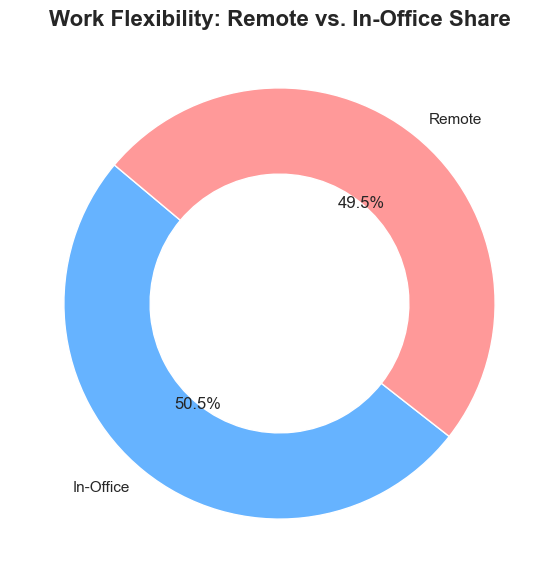

In [8]:
# --- REMOTE WORK ANALYSIS ---
# Map True/False to text labels first to ensure accuracy
remote_counts = df['is_remote'].map({True: 'Remote', False: 'In-Office'}).value_counts()

# 2. Plot (Donut Chart Style)
plt.figure(figsize=(7, 7))

# 'wedgeprops'is used to create the  (Donut Chart)
plt.pie(remote_counts, 
        labels=remote_counts.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=['#66b3ff', '#ff9999'], 
        wedgeprops={'width': 0.4}) # width < 1 creates the hole

plt.title('Work Flexibility: Remote vs. In-Office Share', fontsize=16, fontweight='bold')
plt.show()

*Saving Dataset*

In [9]:

df.to_csv("final_internship_data.csv", index=False)
print("file 'final_internship_data.csv' is ready.")


file 'final_internship_data.csv' is ready.
